In [2]:
import numpy as np  
import pandas as pd  
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os
from scipy import stats
from scipy.stats import norm, skew 

plt.rc("font",family="SimHei",size="15") 

%matplotlib inline 

# data setting


In [3]:
from sklearn.pipeline import make_pipeline #pipeline
from sklearn.preprocessing import RobustScaler 
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone #自定义类的API
from sklearn.model_selection import KFold, cross_val_score, train_test_split #交叉验证
from sklearn.metrics import mean_squared_error 
import torch
from torch import nn
# import lightgbm as lgb #lightGBM
train = pd.read_csv("data2/X_train.csv")
test = pd.read_csv("data2/X_test.csv")

X_train = train.drop("SalePrice",axis=1)
X_test = test.drop("SalePrice",axis=1)

y_train = train["SalePrice"]
y_test= test["SalePrice"]

In [4]:
torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,Street,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1.8,0.454545,-0.191453,0.0,0.0,0.0,0.0,2.0,-0.187500,-0.815789,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,0.0
1,0.0,0.000000,-0.289205,0.0,0.0,0.0,-0.5,0.0,0.729167,0.342105,...,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,1.0
2,0.0,0.136364,-0.218961,0.0,0.0,0.0,0.5,0.0,0.687500,0.289474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.409091,0.174260,0.0,0.0,0.0,-0.5,2.0,-0.145833,-0.763158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.318182,0.105735,0.0,0.0,1.0,-0.5,0.0,0.041667,-0.500000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
from sklearn.preprocessing import RobustScaler

# Assuming X_train, X_test, y_train, y_test are your dataframes or arrays

# 將 X_train 和 X_test 轉換為張量並移動到指定設備上
x_in = torch.tensor(X_train.values, device=device, dtype=torch.float)
x_val = torch.tensor(X_test.values, device=device, dtype=torch.float)

# 對 y_train 和 y_test 進行 RobustScaler 縮放後轉換為張量
scaler = RobustScaler()
y_in_s = torch.tensor(scaler.fit_transform(y_train.values.reshape(-1, 1)), device=device, dtype=torch.float)
y_val_s = torch.tensor(scaler.transform(y_test.values.reshape(-1, 1)), device=device, dtype=torch.float)

# 將 y_train 和 y_test 直接轉換為張量
y_in = torch.tensor(y_train.values, device=device, dtype=torch.float)
y_val = torch.tensor(y_test.values, device=device, dtype=torch.float)

In [7]:
#Xavier initialization
def init_weights(m, k=1, gain=100):
    for i in m:
        if isinstance(i, nn.Linear):
            nn.init.xavier_normal_(i.weight, gain=gain)
            i.bias.data.fill_(k)

#l2 reguliaztion
def l2_loss(model, lambda0 = 0.001):
    paras = []
    for para in model.parameters():
        paras.append(para.view(-1))
    return lambda0* torch.square(torch.cat(paras)).sum()
#set DO and BN layer
def DO_BN(model,DO:bool,BN:bool):
    dropout_probs = [ 0.1,0.1,0.1]
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p =  dropout_probs.pop(0) if DO else 0
        if isinstance(module, nn.BatchNorm1d) or isinstance(module, nn.BatchNorm2d):
            module.track_running_stats = BN

def forward(model,x,y,l2):
    y_pred = model(x)
    loss = nn.functional.mse_loss(y_pred,y).to(device)
    if l2:
        loss+=  l2_loss(model)
    return loss
    


def node_pruning_(model):
    k = 1
    while k>p:
        output_model = model
        p-=1
    



'def UA_module(model,l2,eta=1.2,epshon=0.7 ):\n    forward(model,x_in,l2)'

In [8]:
#trian process
def training(model,EB = True, LG = False,UA= False, DO = False, BN = False, l2 = True,
             regulization = True,initial_lr = 1e-3, stopping_lr = 6e-5, stopping_error = 0.05 , stopping_epochs = 75):
    
    #set old model to output_model when running regulization
    if regulization:
        output_model = model
    else:
        init_weights(model,0.1,1)
   
   #activate DO and BNlayer or not
    DO_BN(model,DO,BN)

    # Disable tracking running statistics
    if UA and DO: print("Warning: Some error may occur for DO+ReduceLROnPlateau scheduler. Consider changing to CosineAnnealingLR scheduler.")



    #set Adam to be optimizer 
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)

    #set learning scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10,verbose=True,
                                                              cooldown=10, min_lr=0, eps=1e-05)
    #lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=1.2, patience=20,verbose=True,
    #                                                          cooldown=0, min_lr=0, eps=1e-05)
     
    epochs = 0
    loss_in_list = []
    loss_out_list = []
    
    while True:
        #forward
        epochs += 1
        model.eval()# 切換到評估模式
        loss_out = forward(model,x_val,y_val_s,l2)

        model.train()  # 切換到訓練模式
        loss_in = forward(model,x_in,y_in_s,l2)
  
        #store loss values
        loss_in_list.append(loss_in.item())
        loss_out_list.append(loss_out.item())
        
        #check LG critiria
        if (loss_in < stopping_error) & LG:    
            print("LG stop")
            break      

        #backward
        optimizer.zero_grad()
        loss_in.backward()
        optimizer.step()
        #check UA critiria
        lr_scheduler.step(loss_in)
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epochs}: Loss In {loss_in.item()}, Loss Out {loss_out.item()}, Learning Rate {current_lr}')
        if  UA :
            for param_group in optimizer.param_groups:
                    param_group['lr'] *= 1.02
            if (current_lr<stopping_lr) :
                print('UA stop')
                break
        if regulization:
            output_model = model
            print('update new model')                 



        #check EB critiria
        if (epochs >= stopping_epochs) & EB:
            print("EB stop")
            if regulization:
                if ~UA and ~LG and (loss_in < stopping_error):
                    output_model = model
                    print('new model accept')
                else:
                    print("unacceptable model")
            break


    print(f'Training finished in {epochs} epochs.')
    
    if regulization:
        return loss_in_list,loss_out_list,stopping_error, output_model
    return loss_in_list, loss_out_list, stopping_error


In [9]:
#plot error
def draw_lr_step(loss_in_list,loss_out_list,stopping_error):
    # Assuming you have the epoch numbers as a list
    epoch_list = list(range(1, len(loss_in_list)+1))

    # Assuming you have the lists for loss_in and loss_out

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, loss_in_list, label='Loss In')
    plt.plot(epoch_list, loss_out_list, label='Loss Out')
    plt.axhline(y=stopping_error, color='gray', linestyle='--',
                linewidth=1.5, label='Stopping Value = '+str(stopping_error))
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss of LG weight tuning')
    plt.legend()
    plt.ylim(0, 1)
    plt.scatter(epoch_list[-1], loss_out_list[-1], color='red', s=100, label='Last Point out')
    plt.text(epoch_list[-1], loss_out_list[-1]+0.03, f'  {loss_out_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.scatter(epoch_list[-1], loss_in_list[-1], color='red', s=100, label='Last Point in')
    plt.text(epoch_list[-1], loss_in_list[-1]+0.03, f'  {loss_in_list[-1]:.4f}', verticalalignment='bottom', horizontalalignment='right', color='red')
    plt.grid(True)
    plt.show()


In [10]:
def draw_pred_reggsion(model,print_error = True):
    model.eval()
    y_pred_val_s = model(x_val)
    loss1 = nn.functional.mse_loss(y_pred_val_s,y_val_s)
    y_pred_val = torch.Tensor(scaler.inverse_transform(torch.Tensor.cpu(y_pred_val_s).detach().numpy()))
    loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))
    if print_error:
        print(torch.Tensor.cpu(loss1).tolist())
        print(torch.Tensor.cpu(loss2).tolist())
        

    y_pred_val_list = y_pred_val.tolist()
    y_val_list = y_val.tolist()
    # Perform linear regression
    slope, intercept = np.polyfit(np.array(y_pred_val_list).flatten(), np.array(y_val_list).flatten(), 1)

    plt.figure(figsize=(10, 6))
    plt.plot(y_pred_val_list, y_val_list, 'o', label='Data points')
    plt.plot(y_pred_val_list, np.array(y_pred_val_list) * slope + intercept, '-', label='Regression line')
    plt.xlabel('Prediction')
    plt.ylabel('House Price')
    plt.title('Regression line between Prediction and House Price')
    plt.legend()
    plt.grid(True)
    plt.show()



## Best Model: 11 hidden  with RELU act

In [52]:
N, D_in,  D_out = 978, 214, 1
p = [ 0.1,0.3,0.3]

model_11 = nn.Sequential(
    nn.Linear(D_in, 100),
    nn.BatchNorm1d(100, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(100, 50),
    nn.BatchNorm1d(50, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(50, 11),
    nn.BatchNorm1d(11, track_running_stats=False),  # BatchNorm1d after the linear layer, not activate
    nn.LeakyReLU(),
    nn.Dropout(p=0),  # Dropout
    nn.Linear(11, D_out)
)
if torch.cuda.is_available():
    model_11.cuda()
    
models_EB_accept = []
models_EB_regulization = []

### 1. weight tuning EB  + regularizing_EB with l2  loss 

#### train with EB

In [42]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 500

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_accept.append(model_11)



Epoch 1: Loss In 0.8737521767616272, Loss Out 1.0436506271362305, Learning Rate 0.001
Epoch 2: Loss In 0.8433362245559692, Loss Out 1.0210615396499634, Learning Rate 0.001
Epoch 3: Loss In 0.8256359100341797, Loss Out 1.0113691091537476, Learning Rate 0.001
Epoch 4: Loss In 0.8147491812705994, Loss Out 1.0091040134429932, Learning Rate 0.001
Epoch 5: Loss In 0.8087303042411804, Loss Out 1.0087683200836182, Learning Rate 0.001
Epoch 6: Loss In 0.8027357459068298, Loss Out 1.0036505460739136, Learning Rate 0.001
Epoch 7: Loss In 0.7971420884132385, Loss Out 0.9979395270347595, Learning Rate 0.001
Epoch 8: Loss In 0.7920835018157959, Loss Out 0.995956301689148, Learning Rate 0.001
Epoch 9: Loss In 0.78791743516922, Loss Out 0.9976051449775696, Learning Rate 0.001
Epoch 10: Loss In 0.7839903235435486, Loss Out 0.9978814125061035, Learning Rate 0.001
Epoch 11: Loss In 0.7796653509140015, Loss Out 0.9942701458930969, Learning Rate 0.001
Epoch 12: Loss In 0.7753685116767883, Loss Out 0.990951

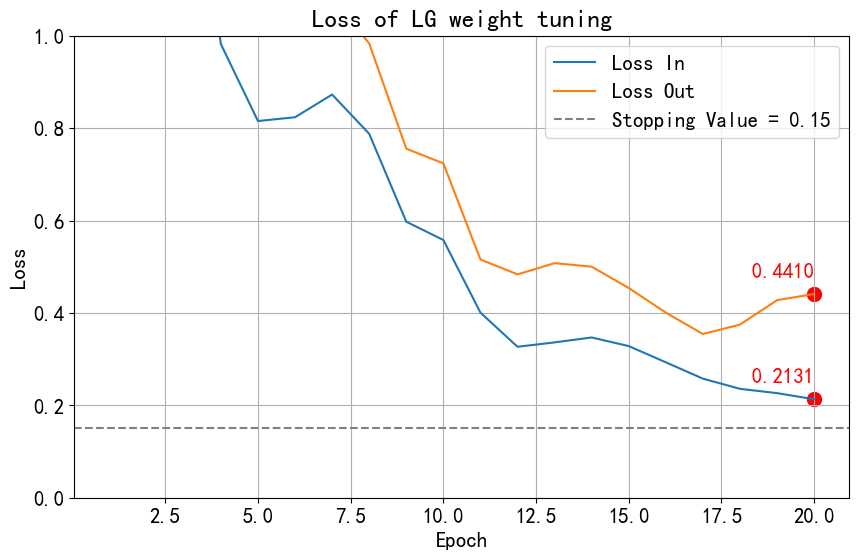

In [54]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.4011618494987488
9173426176.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


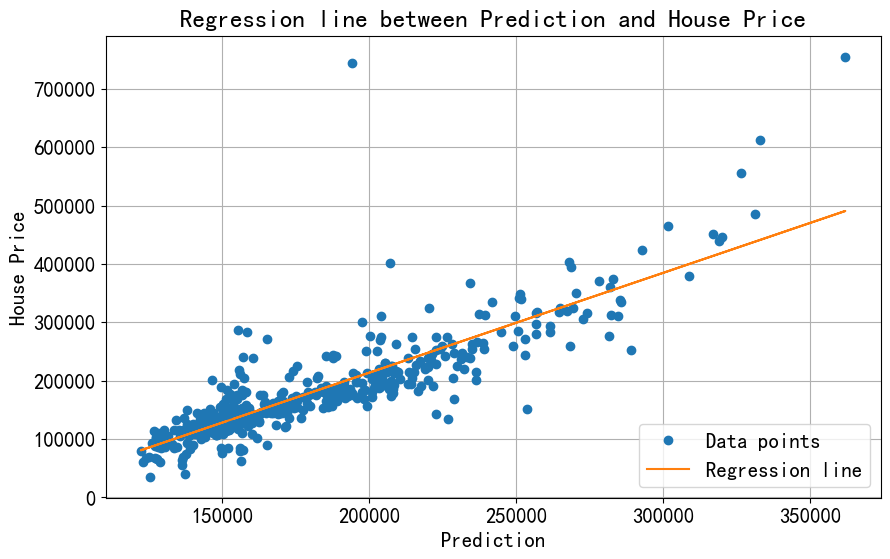

In [55]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB l2

In [59]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-1
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.15
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EB_regulization.append(model_11)

Epoch 1: Loss In 5.825270652770996, Loss Out 6.0029802322387695, Learning Rate 0.1
new model accept
Epoch 2: Loss In 4.64591121673584, Loss Out 5.097957611083984, Learning Rate 0.1
new model accept
Epoch 3: Loss In 3.2534661293029785, Loss Out 3.5797784328460693, Learning Rate 0.1
new model accept
Epoch 4: Loss In 2.441869020462036, Loss Out 2.695284366607666, Learning Rate 0.1
new model accept
Epoch 5: Loss In 1.9784538745880127, Loss Out 2.2196240425109863, Learning Rate 0.1
new model accept
Epoch 6: Loss In 1.6587632894515991, Loss Out 1.8802433013916016, Learning Rate 0.1
new model accept
Epoch 7: Loss In 1.5352494716644287, Loss Out 1.7380657196044922, Learning Rate 0.1
new model accept
Epoch 8: Loss In 1.452344298362732, Loss Out 1.7048118114471436, Learning Rate 0.1
new model accept
Epoch 9: Loss In 1.4504802227020264, Loss Out 1.6925374269485474, Learning Rate 0.1
new model accept
Epoch 10: Loss In 1.3661701679229736, Loss Out 1.6044676303863525, Learning Rate 0.1
new model acc

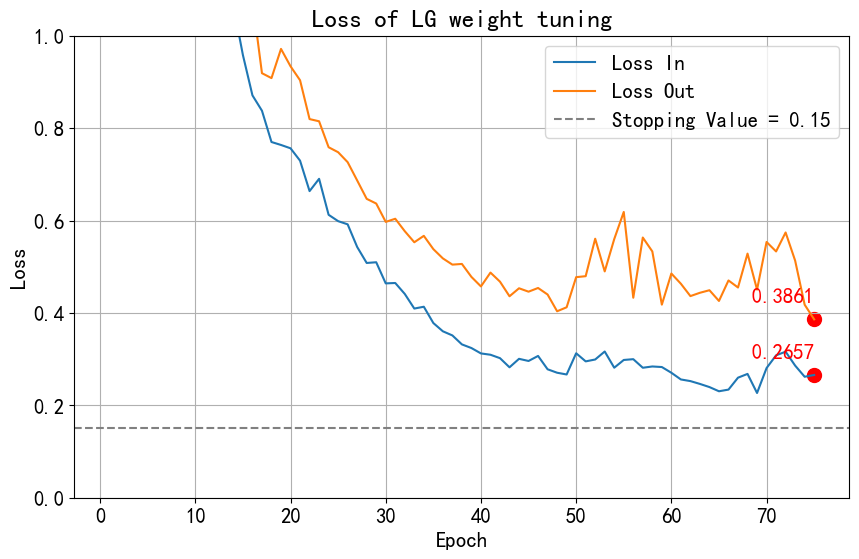

In [60]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2856687009334564
11123357696.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


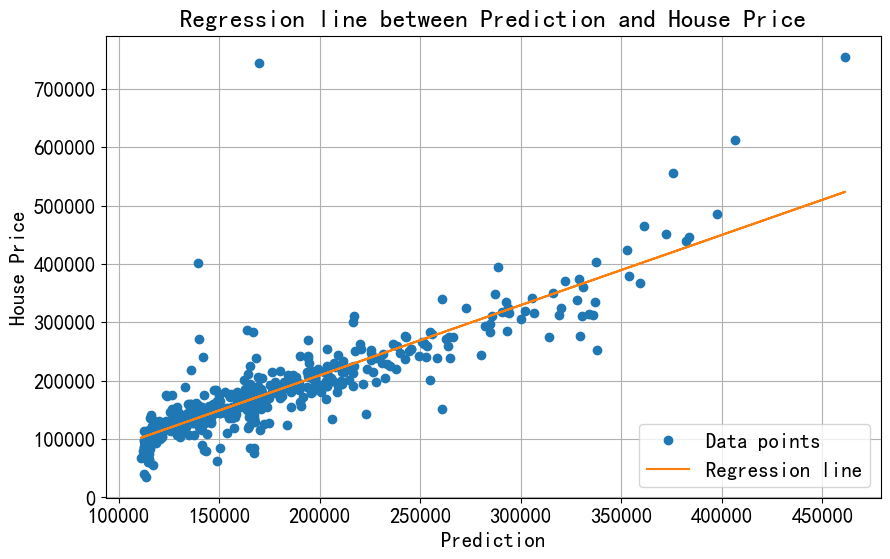

In [61]:
draw_pred_reggsion(model_11,print_error = True)

### 2. weight tuning LG UA  + regularizing_LG UA with l2  loss 

In [62]:
models_LGUA_accept = []
models_LGUA_regulization = []

#### train with LG UA

In [66]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.05 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_accept.append(model_11)



Epoch 1: Loss In 0.9109188914299011, Loss Out 1.1578947305679321, Learning Rate 0.001
Epoch 2: Loss In 0.8860896825790405, Loss Out 1.1319233179092407, Learning Rate 0.00102
Epoch 3: Loss In 0.8636024594306946, Loss Out 1.1060444116592407, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 0.8433654308319092, Loss Out 1.0813953876495361, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 0.8263654112815857, Loss Out 1.0602056980133057, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 0.8123126029968262, Loss Out 1.0425503253936768, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 0.8002970218658447, Loss Out 1.02842116355896, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 0.7897298336029053, Loss Out 1.0172661542892456, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 0.779998242855072, Loss Out 1.008070945739746, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 0.7705729007720947, Loss Out 0.9999249577522278, Learning Rate 0.0011950925686223112
Epoch 11: Los

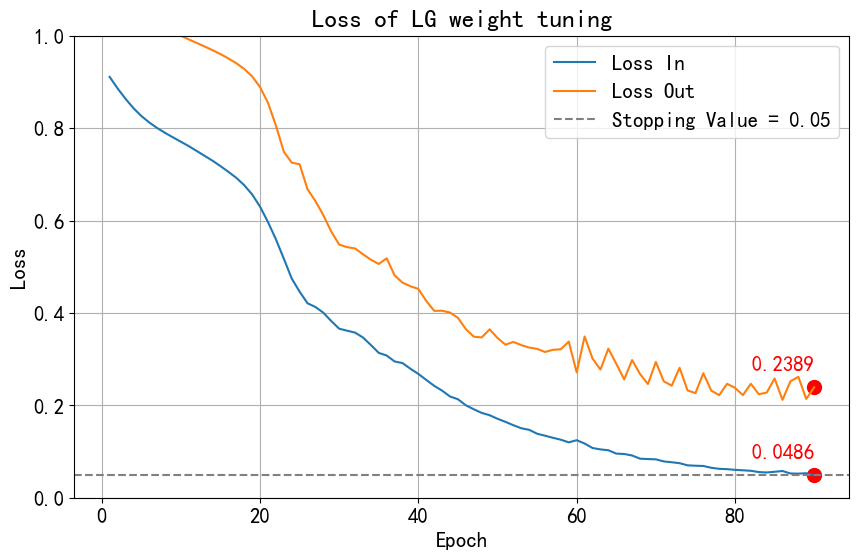

In [67]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.23891681432724
11996929024.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


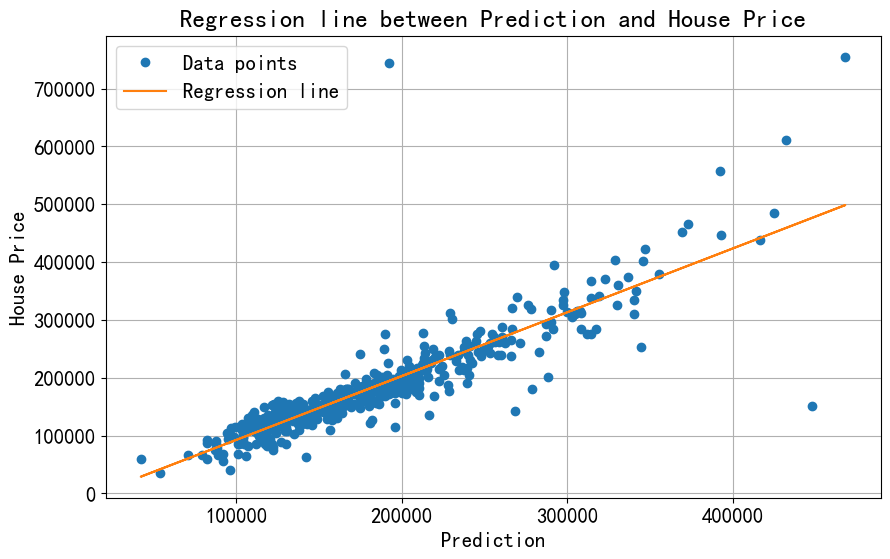

In [68]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with LG UA l2

In [71]:
EB = False
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_LGUA_regulization.append(model_11)

Epoch 1: Loss In 0.24798621237277985, Loss Out 0.48960769176483154, Learning Rate 0.001
new model accept
Epoch 2: Loss In 0.352245569229126, Loss Out 0.6041317582130432, Learning Rate 0.00102
new model accept
Epoch 3: Loss In 0.25824591517448425, Loss Out 0.47619590163230896, Learning Rate 0.0010404000000000001
new model accept
Epoch 4: Loss In 0.2621687352657318, Loss Out 0.4734516143798828, Learning Rate 0.0010612080000000001
new model accept
Epoch 5: Loss In 0.267059326171875, Loss Out 0.4955703616142273, Learning Rate 0.0010824321600000002
new model accept
Epoch 6: Loss In 0.2837560176849365, Loss Out 0.5586750507354736, Learning Rate 0.0011040808032000001
new model accept
Epoch 7: Loss In 0.2644430994987488, Loss Out 0.5004419684410095, Learning Rate 0.0011261624192640003
new model accept
Epoch 8: Loss In 0.2613453269004822, Loss Out 0.46740424633026123, Learning Rate 0.0011486856676492802
new model accept
Epoch 9: Loss In 0.25372403860092163, Loss Out 0.4563570022583008, Learning

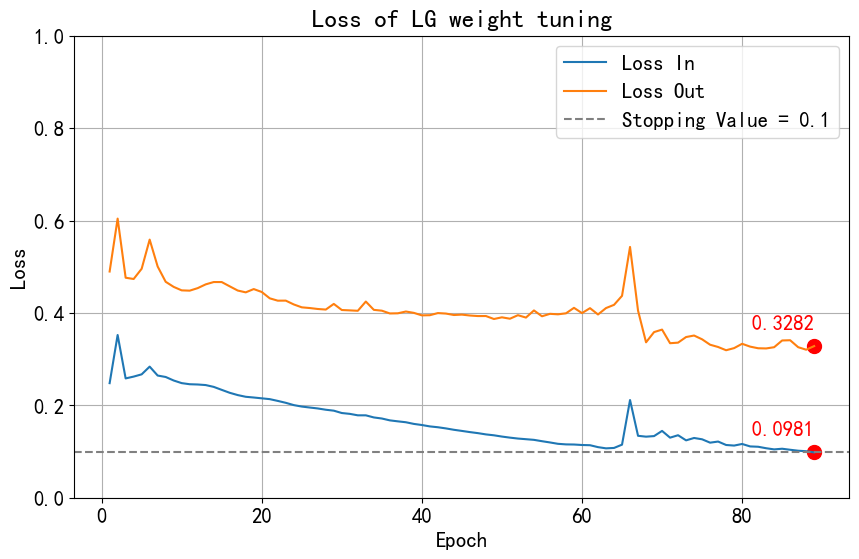

In [72]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.26863449811935425
11832201216.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


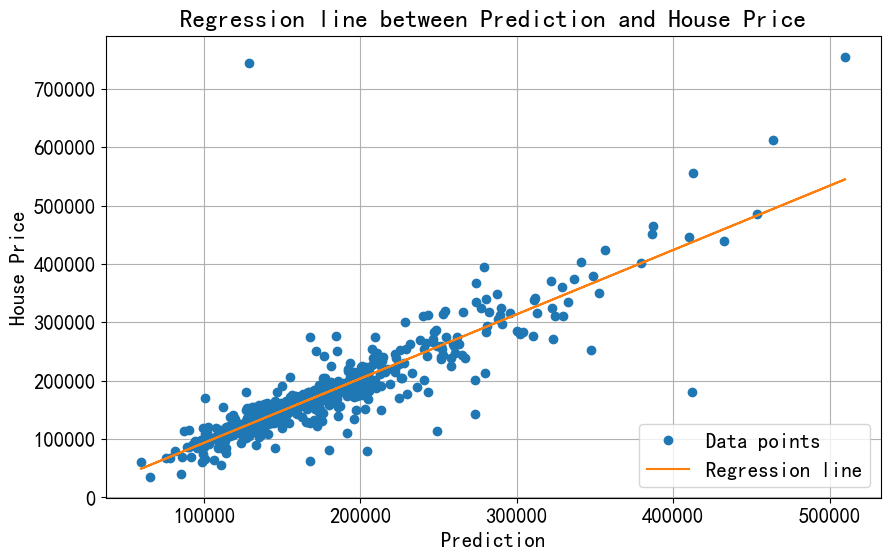

In [73]:
draw_pred_reggsion(model_11,print_error = True)

### 3. weight tuning EB LG UA  + regularizing EB LG UA  with l2  loss 

In [74]:
models_EBLGUA_accept = []
models_EBLGUA_regulization = []

#### train with EB LG UA 

In [76]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.15 if l2 else 0.05
stopping_epochs = 100

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_accept.append(model_11)



Epoch 1: Loss In 1.086812138557434, Loss Out 1.2567329406738281, Learning Rate 0.001
Epoch 2: Loss In 1.0108450651168823, Loss Out 1.2230784893035889, Learning Rate 0.00102
Epoch 3: Loss In 0.9581644535064697, Loss Out 1.199109673500061, Learning Rate 0.0010404000000000001
Epoch 4: Loss In 0.9252029657363892, Loss Out 1.1761544942855835, Learning Rate 0.0010612080000000001
Epoch 5: Loss In 0.900714635848999, Loss Out 1.1565097570419312, Learning Rate 0.0010824321600000002
Epoch 6: Loss In 0.8792505264282227, Loss Out 1.1374666690826416, Learning Rate 0.0011040808032000001
Epoch 7: Loss In 0.8574103713035583, Loss Out 1.1176685094833374, Learning Rate 0.0011261624192640003
Epoch 8: Loss In 0.8351500034332275, Loss Out 1.0973048210144043, Learning Rate 0.0011486856676492802
Epoch 9: Loss In 0.8131809830665588, Loss Out 1.0772206783294678, Learning Rate 0.0011716593810022658
Epoch 10: Loss In 0.7930008172988892, Loss Out 1.0572353601455688, Learning Rate 0.0011950925686223112
Epoch 11: Lo

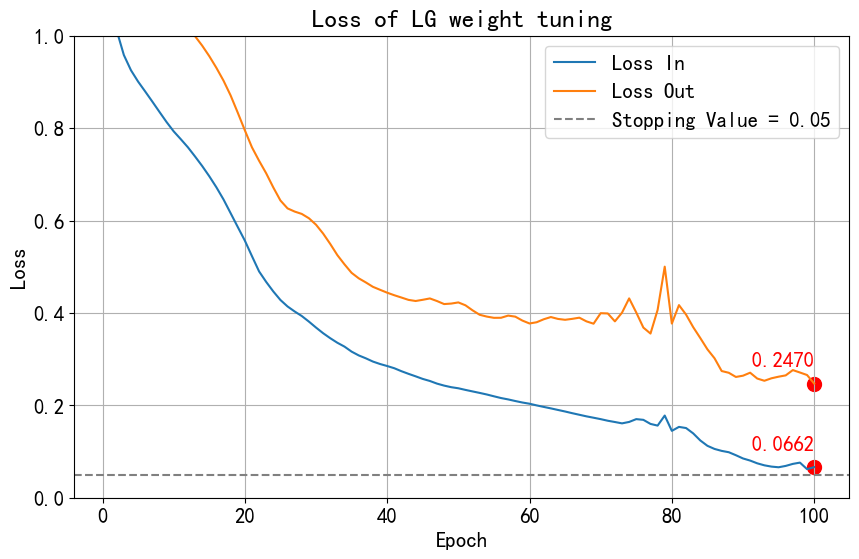

In [77]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.2638154923915863
11827217408.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


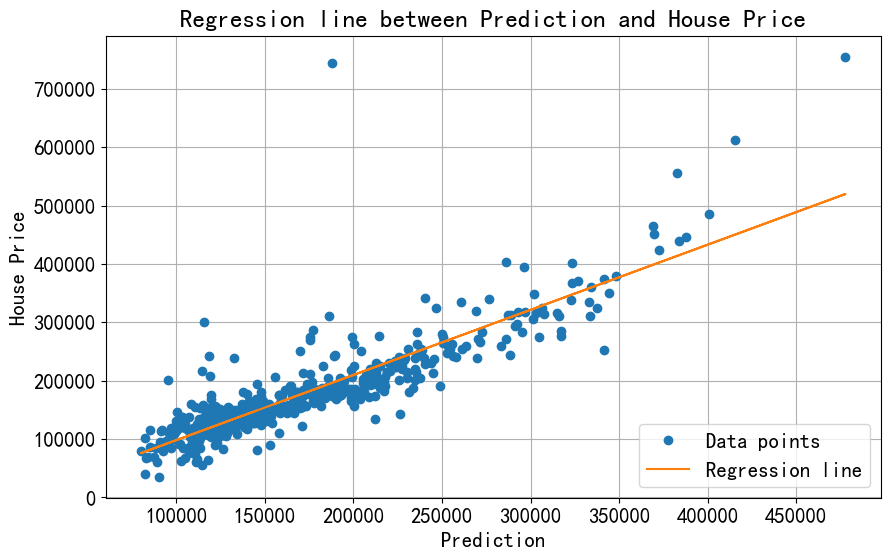

In [78]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB LG UA l2

In [79]:
EB = True
LG = True
UA= True
DO = False
BN = False
l2 = True
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBLGUA_regulization.append(model_11)

Epoch 1: Loss In 0.5373278856277466, Loss Out 0.726884126663208, Learning Rate 0.001
new model accept
Epoch 2: Loss In 0.5178371071815491, Loss Out 0.6972466111183167, Learning Rate 0.00102
new model accept
Epoch 3: Loss In 0.5169017314910889, Loss Out 0.7125669717788696, Learning Rate 0.0010404000000000001
new model accept
Epoch 4: Loss In 0.5036190152168274, Loss Out 0.709109365940094, Learning Rate 0.0010612080000000001
new model accept
Epoch 5: Loss In 0.49811479449272156, Loss Out 0.7051550149917603, Learning Rate 0.0010824321600000002
new model accept
Epoch 6: Loss In 0.49484172463417053, Loss Out 0.6979414224624634, Learning Rate 0.0011040808032000001
new model accept
Epoch 7: Loss In 0.4872435927391052, Loss Out 0.6837801933288574, Learning Rate 0.0011261624192640003
new model accept
Epoch 8: Loss In 0.4792606830596924, Loss Out 0.6697906255722046, Learning Rate 0.0011486856676492802
new model accept
Epoch 9: Loss In 0.47472500801086426, Loss Out 0.6646809577941895, Learning Ra

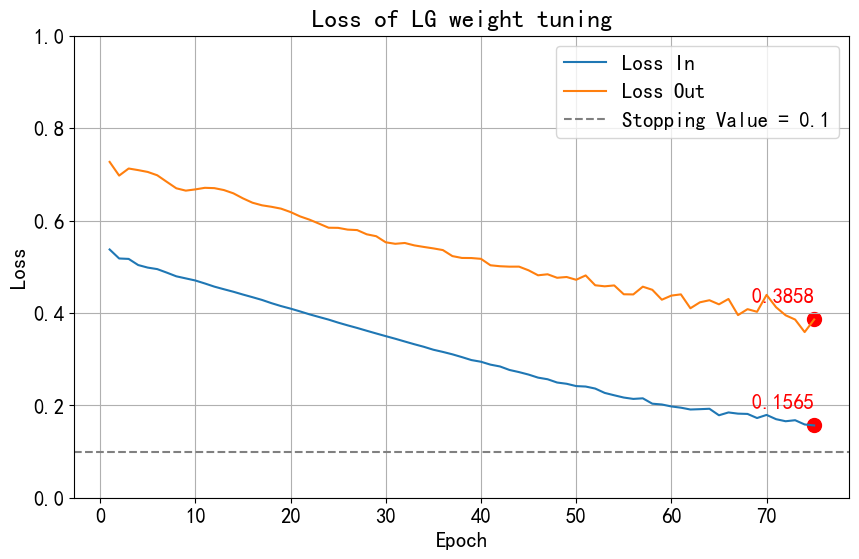

In [80]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.28650549054145813
11648909312.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


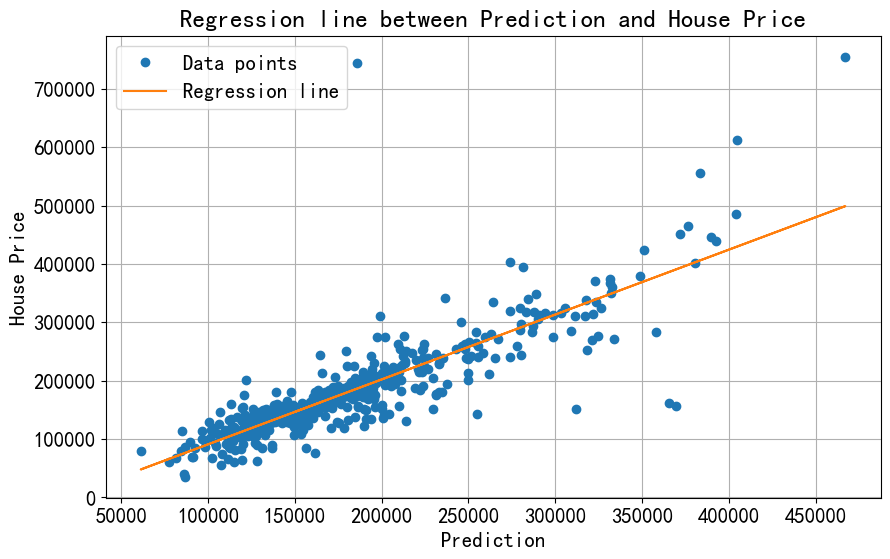

In [81]:
draw_pred_reggsion(model_11,print_error = True)

### 4. weight tuning EB   + regularizing EB DO

In [82]:
models_EBDO_accept = []
models_EBDO_regulization = []

#### train with EB 

In [101]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_accept.append(model_11)



Epoch 1: Loss In 1.3470124006271362, Loss Out 1.7956154346466064, Learning Rate 0.001
Epoch 2: Loss In 1.1587291955947876, Loss Out 1.525865077972412, Learning Rate 0.001
Epoch 3: Loss In 1.0242090225219727, Loss Out 1.3400481939315796, Learning Rate 0.001
Epoch 4: Loss In 0.9334673881530762, Loss Out 1.212951898574829, Learning Rate 0.001
Epoch 5: Loss In 0.8763022422790527, Loss Out 1.1307998895645142, Learning Rate 0.001
Epoch 6: Loss In 0.8433651328086853, Loss Out 1.0772463083267212, Learning Rate 0.001
Epoch 7: Loss In 0.817384660243988, Loss Out 1.0429211854934692, Learning Rate 0.001
Epoch 8: Loss In 0.7990347743034363, Loss Out 1.019662857055664, Learning Rate 0.001
Epoch 9: Loss In 0.7840465903282166, Loss Out 1.0030162334442139, Learning Rate 0.001
Epoch 10: Loss In 0.7700411081314087, Loss Out 0.9895471334457397, Learning Rate 0.001
Epoch 11: Loss In 0.7561254501342773, Loss Out 0.9777013659477234, Learning Rate 0.001
Epoch 12: Loss In 0.7428732514381409, Loss Out 0.9662806

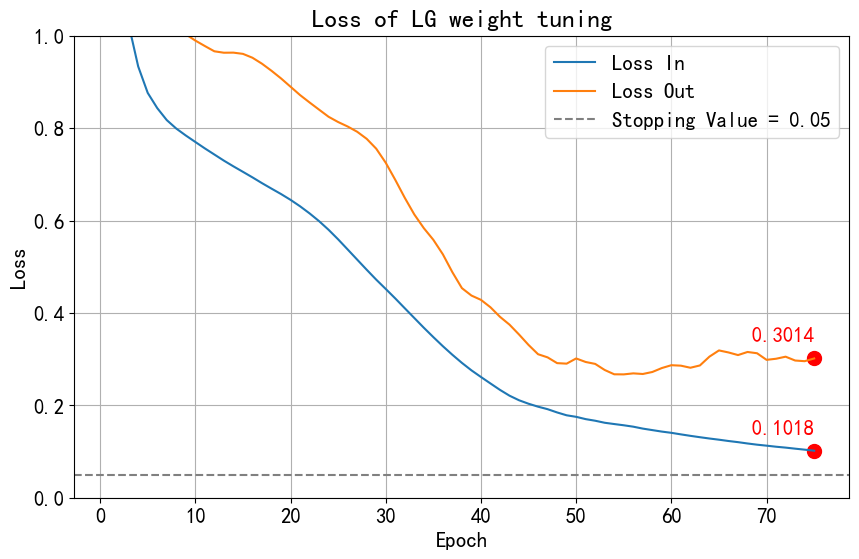

In [102]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.30411389470100403
12822299648.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


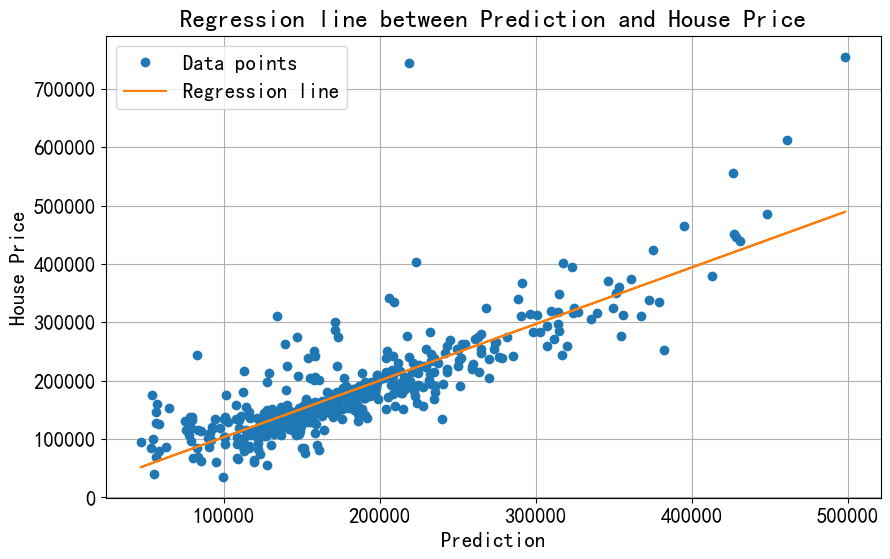

In [103]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [104]:
EB = True
LG = False
UA= False
DO = True
BN = False
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBDO_regulization.append(model_11)

Epoch 1: Loss In 0.6421376466751099, Loss Out 0.30411389470100403, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.5471259951591492, Loss Out 0.4886404871940613, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.5565440058708191, Loss Out 0.6077987551689148, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.4385630488395691, Loss Out 0.548787534236908, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.5039022564888, Loss Out 0.4970521628856659, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.468938946723938, Loss Out 0.42838090658187866, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.4051414430141449, Loss Out 0.4081907868385315, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.47026100754737854, Loss Out 0.4011361002922058, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.47894272208213806, Loss Out 0.38694238662719727, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.4162043035030365, Loss Out 0.3670252859592438, Learni

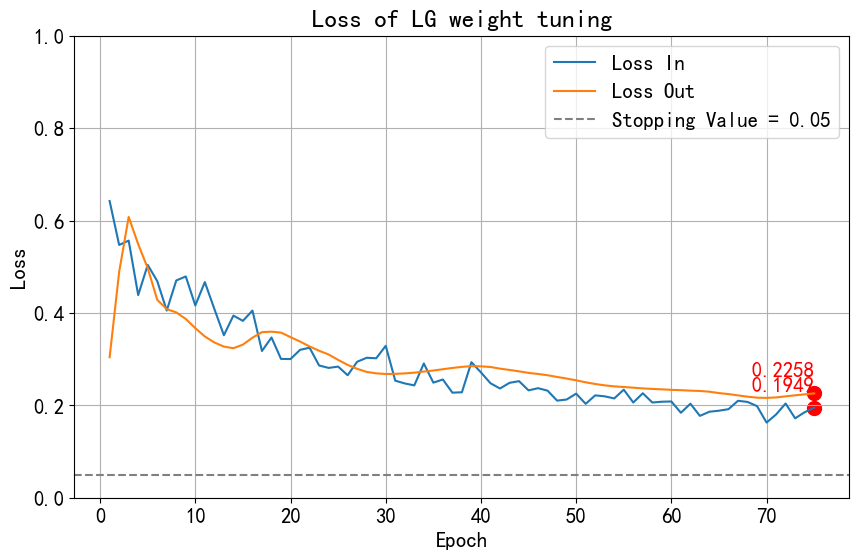

In [105]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.22903701663017273
12126996480.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


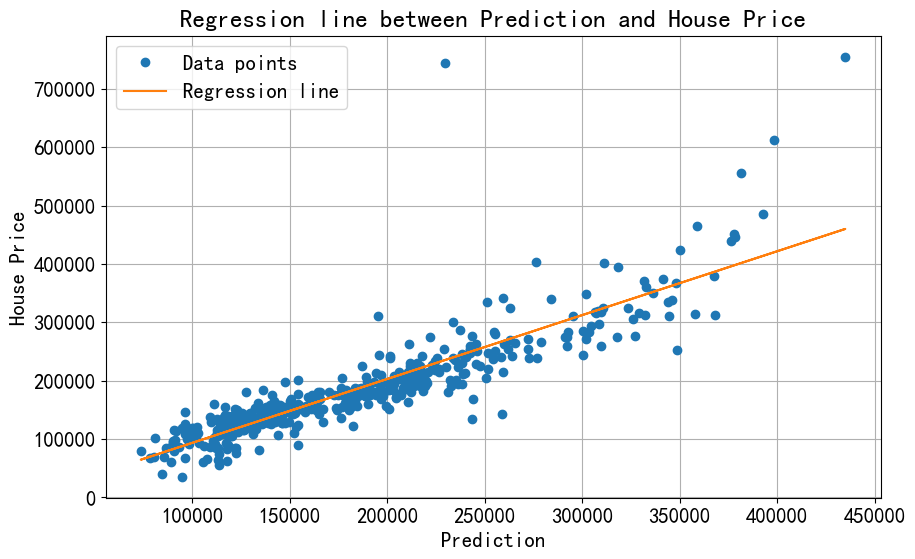

In [106]:
draw_pred_reggsion(model_11,print_error = True)

### 5. weight tuning EB   + regularizing EB DO

In [107]:
models_EBBN_accept = []
models_EBBN_regulization = []

#### train with EB 

In [108]:
EB = True
LG = False
UA= False
DO = False
BN = False
l2 = False
regulization = False
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 75

loss_in_list, loss_out_list, stopping_error = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_accept.append(model_11)



Epoch 1: Loss In 1.9861416816711426, Loss Out 2.307358503341675, Learning Rate 0.001
Epoch 2: Loss In 1.852182149887085, Loss Out 2.176486015319824, Learning Rate 0.001
Epoch 3: Loss In 1.7492300271987915, Loss Out 2.081301212310791, Learning Rate 0.001
Epoch 4: Loss In 1.6674680709838867, Loss Out 1.9975229501724243, Learning Rate 0.001
Epoch 5: Loss In 1.6073306798934937, Loss Out 1.9411717653274536, Learning Rate 0.001
Epoch 6: Loss In 1.5644303560256958, Loss Out 1.911637783050537, Learning Rate 0.001
Epoch 7: Loss In 1.5239918231964111, Loss Out 1.877960205078125, Learning Rate 0.001
Epoch 8: Loss In 1.4837334156036377, Loss Out 1.837769865989685, Learning Rate 0.001
Epoch 9: Loss In 1.4441288709640503, Loss Out 1.7885725498199463, Learning Rate 0.001
Epoch 10: Loss In 1.4060287475585938, Loss Out 1.7357048988342285, Learning Rate 0.001
Epoch 11: Loss In 1.370495080947876, Loss Out 1.6818968057632446, Learning Rate 0.001
Epoch 12: Loss In 1.3403751850128174, Loss Out 1.63376033306

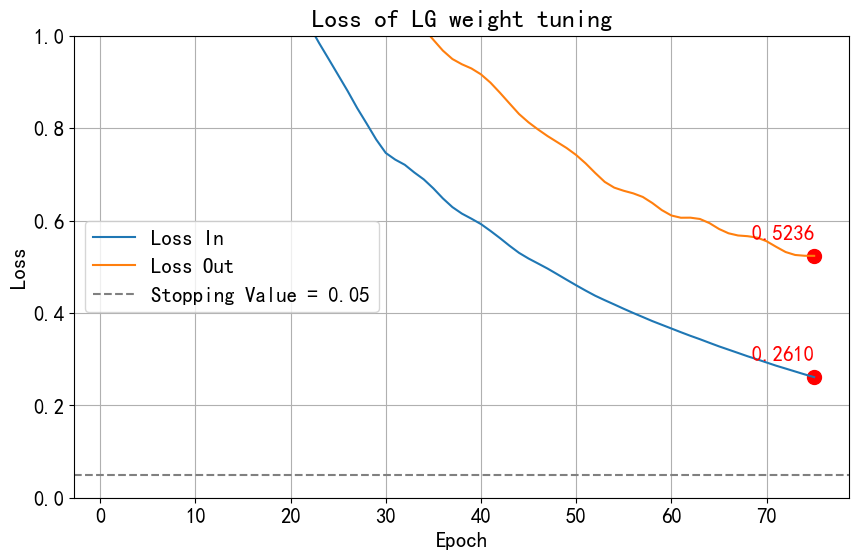

In [109]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.5166227221488953
10200172544.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


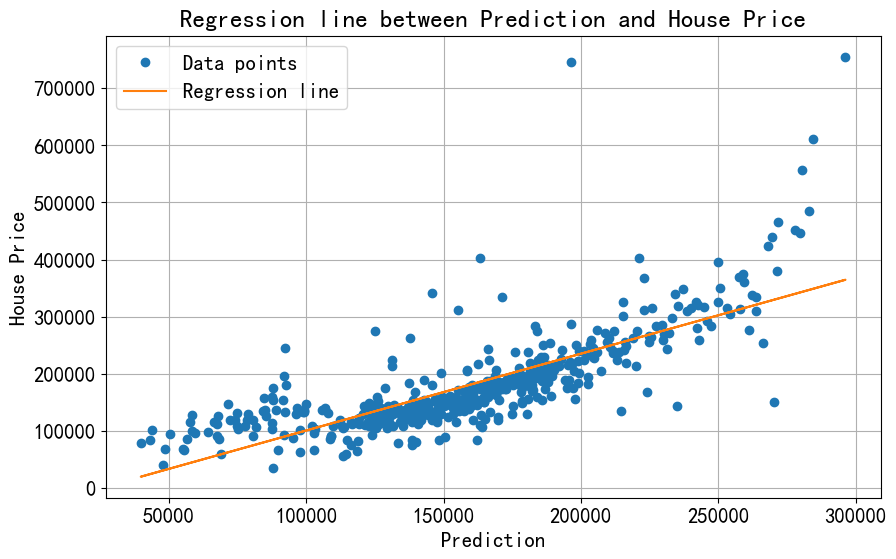

In [110]:
draw_pred_reggsion(model_11,print_error = True)

#### regulization with EB DO

In [113]:
EB = True
LG = False
UA= False
DO = False
BN = True
l2 = False
regulization = True
initial_lr = 1e-3
stopping_lr = 6e-4
stopping_error = 0.1 if l2 else 0.05
stopping_epochs = 50

loss_in_list, loss_out_list, stopping_error, model_11 = training(model_11,EB = EB, LG = LG,UA= UA, DO = DO, BN = BN, l2 = l2,
             regulization = regulization,initial_lr = initial_lr, stopping_lr = stopping_lr, stopping_error = stopping_error, stopping_epochs = stopping_epochs)
  
models_EBBN_regulization.append(model_11)

Epoch 1: Loss In 0.03298895061016083, Loss Out 0.5043054223060608, Learning Rate 0.001
update new model
Epoch 2: Loss In 0.22212207317352295, Loss Out 0.7814711332321167, Learning Rate 0.001
update new model
Epoch 3: Loss In 0.11840333789587021, Loss Out 0.4219760000705719, Learning Rate 0.001
update new model
Epoch 4: Loss In 0.09133898466825485, Loss Out 0.3173542618751526, Learning Rate 0.001
update new model
Epoch 5: Loss In 0.06582712382078171, Loss Out 0.3204265534877777, Learning Rate 0.001
update new model
Epoch 6: Loss In 0.08654137700796127, Loss Out 0.3772296905517578, Learning Rate 0.001
update new model
Epoch 7: Loss In 0.08780194073915482, Loss Out 0.37849104404449463, Learning Rate 0.001
update new model
Epoch 8: Loss In 0.07051976770162582, Loss Out 0.3411061465740204, Learning Rate 0.001
update new model
Epoch 9: Loss In 0.06072121486067772, Loss Out 0.3043966293334961, Learning Rate 0.001
update new model
Epoch 10: Loss In 0.0590682327747345, Loss Out 0.29634559154510

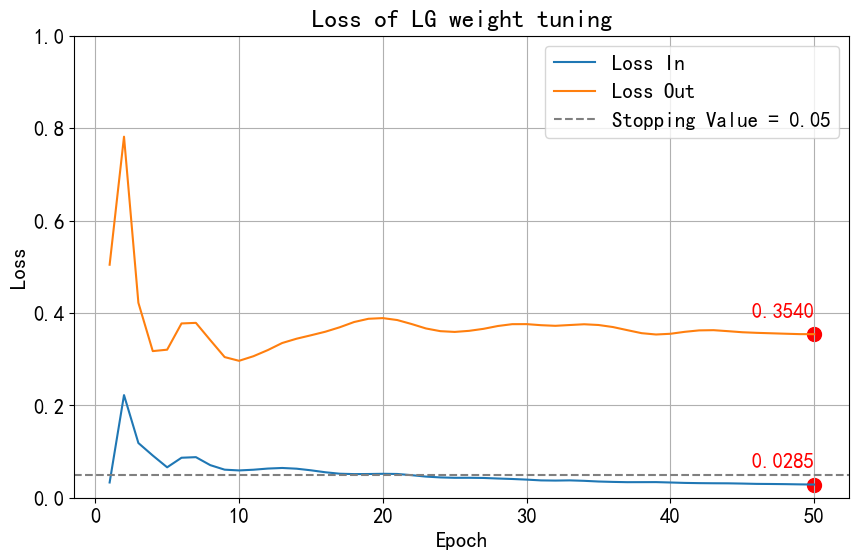

In [114]:
draw_lr_step(loss_in_list,loss_out_list,stopping_error)

0.3556588888168335
11841227776.0


C:\Users\IanKu\AppData\Local\Temp\ipykernel_24792\2668975548.py:6: UserWarning: Using a target size (torch.Size([482])) that is different to the input size (torch.Size([482, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss2 = nn.functional.mse_loss(y_pred_val,torch.Tensor.cpu(y_val))


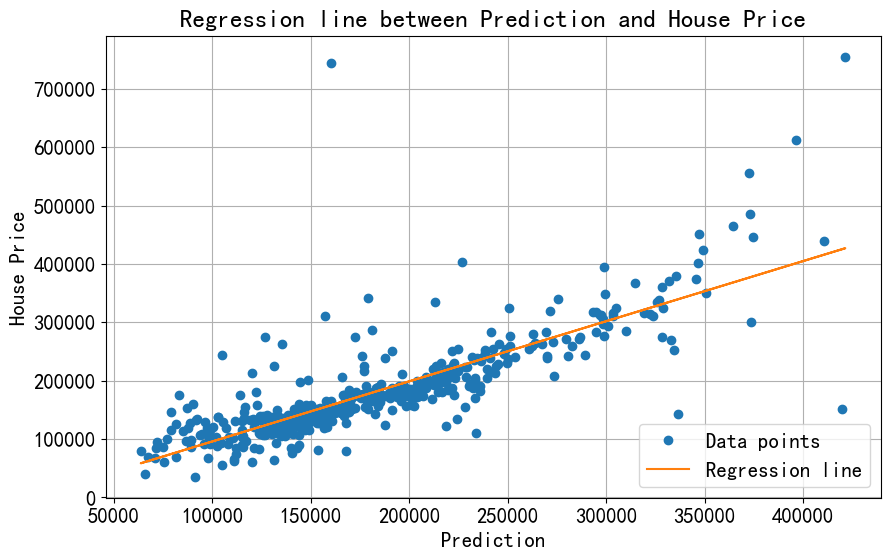

In [115]:
draw_pred_reggsion(model_11,print_error = True)

## Conclusion
#### HW4Update 
#### 1.這次把程式整個大改，把訓練與regulization分開，並且寫成一個訓練的函數，可以選擇是否要EB、LG、UA、DO、BN以及調整訓練模式與regulization模式，雖然最後的code在LG+UA的地方和老師有些差異(老師的LG判定放在迴圈最後，我把LG放在forward後面)，但結果看下來是好的。
#### 2.將訓練與regulization分開後，訓練成本大幅下降，從原本50000步左右變成大約75步，應該是因為加上l2後損失函數圖形變得太複雜，以及沒有l2的話超過75步後容易overfitting導致。一開始把l2丟掉時沒有發現overfitting，等到後來發現model 有訓練模式與評估模式，才發現超級大過擬。
#### 3.小問題，DO layer加上去後拿來做UA的ReduceLROnPlateau就失效了，不管loss 多大lr就是不會變，網路上也找不到相關的議題，可能需要跟老師憶起研究一下。

##### HW3Update 這次加上了顯卡支援跑到了大約50000 epochs 左右，效果也稍微有提升，我發現torch 套件的 torch.optim.lr_scheduler 的 ReduceLROnPlateau 就是在做UA的部分

##### HW2update 這次一開始調了一堆參數增加了好幾層但最後結果都不太理想，後來發現一個問題是我Xavier函數沒寫好，幾乎等於沒做，補好之後發現生出來的數字可以調整scale。另一點模型表現增加最多的地方是對y做了scale，用robust scaler 調整並用來訓練，訓練完後再把test 預測出來的結果用inverse_transform轉換回去。

## hidden nodes:
#### 6 layer 改成 4layer  214 100 50 11 1 
## initial weight:
#### Xavier 
## Activation:
#### 主要用LeakyRELU
## Loss:
#### MSE ,把 l2 regulization 去掉後從50000步降到75步...
## Optmizer epoch
#### Adam 
## learning_rate
#### 起始值設10^-3, UA停止值設 6^10-4, 用ReduceLROnPlateau做UA learn rate decay, loss > 0.1時 lr大概在10^-6 上下，到10^-7左右時跑的超慢
## learn rate scheduler
#### 用ReduceLROnPlateau做UA, 每次變成0.9倍, loss 5輪沒降才會調, 停止值設 6^10-4
## DO
#### 每層被丟掉ˋ的機率都是0.1
## BN
#### 做的是BatchNorm1d，不確定和BatchNorm2d有什麼差別
## Ensembles
#### 下次一定做

